In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_error, mean_squared_error
%matplotlib inline 

In [3]:
from mll_calc.all_jobs import uncs, job_dirs

### hi hello

In [25]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
mll_gam = rdrive + 'mll/gam_spec/'
mll_nuc = rdrive + 'mll/nuc_conc/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'

In [5]:
#mll results for uncertainty = 5% (trainset frac = 100%)
#scikit results for trainset frac = 100% (no uncertainty)

In [41]:
job = job_dirs[0]
n29mll = pd.read_csv(mll_nuc + 'train/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d1mll = pd.read_csv(mll_gam + 'd1_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d2mll = pd.read_csv(mll_gam + 'd2_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
mll_df = [n29mll, d1mll, d2mll]

d1mll31 = pd.read_csv(mll_gam + 'd1_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d2mll31 = pd.read_csv(mll_gam + 'd2_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d3mll31 = pd.read_csv(mll_gam + 'd3_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
mll31 = [n29mll, d1mll31, d2mll31, d3mll31]

In [42]:
det = ['nuc29','d1', 'd2', 'd3']
detdesc = ['nuc29', 'd1_hpge', 'd2_hpge', 'd3_czt']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
csv_end = '_scores.csv'
# for dataframes
algcol = ['knn', 'dtree', 'mll', 'pca_knn', 'pca_dtree', 'knn31', 'dtree31']
scrcol  = ['Accuracy', 'Acc Std']
errcol = ['Neg MAE', 'MAE Std']

In [57]:
results = {}
for i, p in enumerate(pred):
    if p == 'reactor':
        levels = [algcol, scrcol]
    else: 
        levels = [algcol, errcol]
    df = pd.DataFrame(index=det, columns=pd.MultiIndex.from_product(levels, names=["Algorithm", "Metric"]))
    for j, d in enumerate(det):
        if d == 'nuc29':
            continue
        knncsv = p + '_knn_tset1.0_' + detdesc[j] + csv_end
        dtrcsv = p + '_dtree_tset1.0_' + detdesc[j] + csv_end
        if d == 'nuc29':
            learn_path = learn_nuc
            # knn113 and knn31 will both have knn nuc 29 as their starting points
            knn31 = knn113 = pd.read_csv(learn_path + d + '/' + knncsv).drop(columns='Unnamed: 0')
            dtr31 = dtr113 = pd.read_csv(learn_path + d + '/' + dtrcsv).drop(columns='Unnamed: 0')
        else:
            learn_path = learn_gam
            knn31 = pd.read_csv(learn_path + d + '_n31/' + knncsv).drop(columns='Unnamed: 0')
            dtr31 = pd.read_csv(learn_path + d + '_n31/' + dtrcsv).drop(columns='Unnamed: 0')
            if d != 'd3':
                knn113 = pd.read_csv(learn_path + d + '_n113/' + knncsv).drop(columns='Unnamed: 0')
                dtr113 = pd.read_csv(learn_path + d + '_n113/' + dtrcsv).drop(columns='Unnamed: 0')
        pcaknn = pd.read_csv(learn_path + 'pca_' + d + '/' + knncsv).drop(columns='Unnamed: 0')
        pcadtr = pd.read_csv(learn_path + 'pca_' + d + '/' + dtrcsv).drop(columns='Unnamed: 0')
        if p == 'reactor':
            metric = 'test_score'
            dfmetric = 'Accuracy'
            dfstd = 'Acc Std'
            if d != 'd3':
                df.loc[d, ('mll', dfmetric)] = accuracy_score(mll_df[j][predmll[i]], mll_df[j]['pred_' + predmll[i]])
            df.loc[d, ('mll31', dfmetric)] = accuracy_score(mll31[j][predmll[i]], mll31[j]['pred_' + predmll[i]])
        else:
            metric = 'test_neg_mean_absolute_error'
            dfmetric = 'Neg MAE'
            dfstd = 'MAE Std'
            if d != 'd3':
                df.loc[d, ('mll', dfmetric)] = -mean_absolute_error(mll_df[j][predmll[i]], mll_df[j]['pred_' + predmll[i]])
            df.loc[d, ('mll31', dfmetric)] = -mean_absolute_error(mll31[j][predmll[i]], mll31[j]['pred_' + predmll[i]])
        df.loc[d, ('mll', dfstd)] = 0.0
        df.loc[d, ('mll31', dfstd)] = 0.0    
        if d != 'd3':
            df.loc[d, ('knn', dfmetric)] = knn113[metric].mean()
            df.loc[d, ('knn', dfstd)] = knn113[metric].std()
            df.loc[d, ('dtree', dfmetric)] = dtr113[metric].mean()
            df.loc[d, ('dtree', dfstd)] = dtr113[metric].std()    
        df.loc[d, ('pca_knn', dfmetric)] = pcaknn[metric].mean()
        df.loc[d, ('pca_knn', dfstd)] = pcaknn[metric].std()
        df.loc[d, ('pca_dtree', dfmetric)] = pcadtr[metric].mean()
        df.loc[d, ('pca_dtree', dfstd)] = pcadtr[metric].std()    
        df.loc[d, ('knn31', dfmetric)] = knn31[metric].mean()
        df.loc[d, ('knn31', dfstd)] = knn31[metric].std()
        df.loc[d, ('dtree31', dfmetric)] = dtr31[metric].mean()
        df.loc[d, ('dtree31', dfstd)] = dtr31[metric].std()
    results[p] = df

In [58]:
results['burnup']

Algorithm      knn             dtree               mll          pca_knn  \
Metric     Neg MAE  MAE Std  Neg MAE  MAE Std  Neg MAE MAE Std  Neg MAE   
nuc29          NaN      NaN      NaN      NaN      NaN     NaN      NaN   
d1        -371.227   2.6726 -241.972  3.61563  -283.35       0 -795.875   
d2        -428.514  2.52542 -269.008  1.64982 -343.381       0 -517.191   
d3             NaN      NaN      NaN      NaN      NaN       0  -457.12   

Algorithm          pca_dtree             knn31           dtree31           \
Metric     MAE Std   Neg MAE  MAE Std  Neg MAE  MAE Std  Neg MAE  MAE Std   
nuc29          NaN       NaN      NaN      NaN      NaN      NaN      NaN   
d1         5.86567  -941.906  5.57807  -380.38  2.76273 -278.263   2.7957   
d2         2.71232   -568.62  3.33551  -423.59  3.29947 -295.575  3.19498   
d3         2.95211  -539.756  3.88002 -447.625  3.98391  -337.61  4.33915   

Algorithm       mll31          
Metric        Neg MAE MAE Std  
nuc29             NaN     NaN  
d1        -286.502517     0.0  
d2        -340.316979     0.0  
d3        -412.104127     0.0

# Plotting

In [9]:
# color dict (use: colors['XColor'])
colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

In [64]:
def plot_curves(pred_param, title):
    plt.clf()
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        ax.set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
    else:
        ax.set_ylabel('Negative MAE', fontsize=20, labelpad=15)
        metric = errcol[0]
    
    plotdf = results[pred_param]
    
    ax.plot(det, plotdf['mll'][metric], 'o-', color=colors['DPurp'], mew=0, ms=5, label='MLL Calc 113')
    ax.plot(det, plotdf['knn'][metric], 'o-', color=colors['DBrwn'], mew=0, ms=5, label='kNN 113')
    ax.plot(det, plotdf['dtree'][metric], 'o-', color=colors['DTeal'], mew=0, ms=5, label='Dec Tree 113')
    ax.plot(det, plotdf['mll31'][metric], 'o-', color=colors['MPurp'], mew=0, ms=5, label='MLL Calc 31')
    ax.plot(det, plotdf['knn31'][metric], 'o-', color=colors['MBrwn'], mew=0, ms=5, label='kNN 31')
    ax.plot(det, plotdf['dtree31'][metric], 'o-', color=colors['MTeal'], mew=0, ms=5, label='Dec Tree 31')
    ax.plot(det, plotdf['pca_knn'][metric], 'o-', color=colors['LBrwn'], mew=0, ms=5, label='PCA kNN')
    ax.plot(det, plotdf['pca_dtree'][metric], 'o-', color=colors['LTeal'], mew=0, ms=5, label='PCA Dec Tree')

    ax.legend(loc='best')
    plt.show()
    

<Figure size 432x288 with 0 Axes>

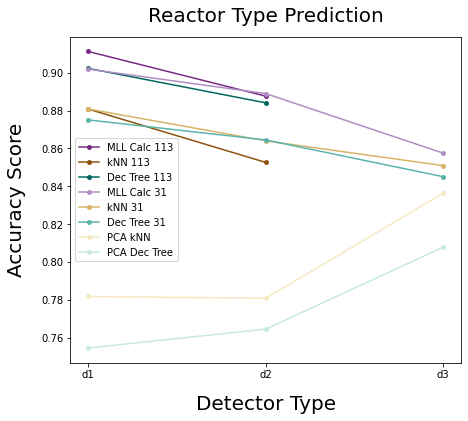

In [65]:
plot_curves('reactor', 'Reactor Type Prediction')

<Figure size 432x288 with 0 Axes>

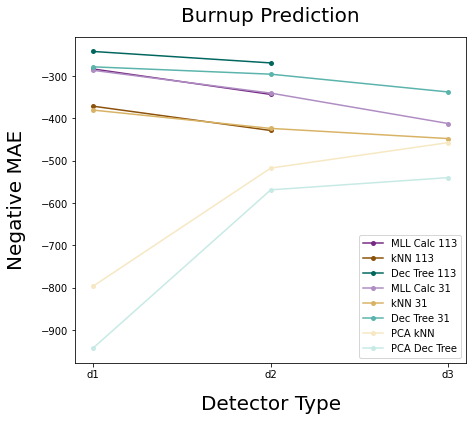

In [66]:
plot_curves('burnup', 'Burnup Prediction')

<Figure size 432x288 with 0 Axes>

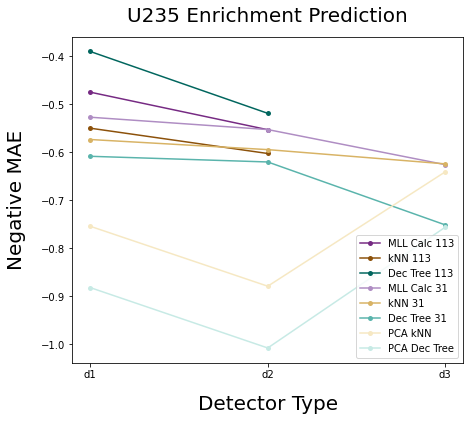

In [67]:
plot_curves('enrichment', 'U235 Enrichment Prediction')

<Figure size 432x288 with 0 Axes>

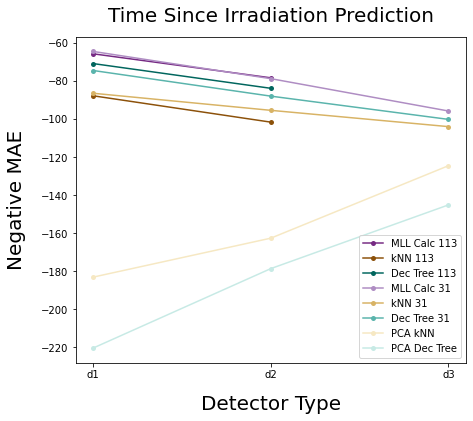

In [68]:
plot_curves('cooling', 'Time Since Irradiation Prediction')

## adding nuclide conc on x axis

<Figure size 432x288 with 0 Axes>

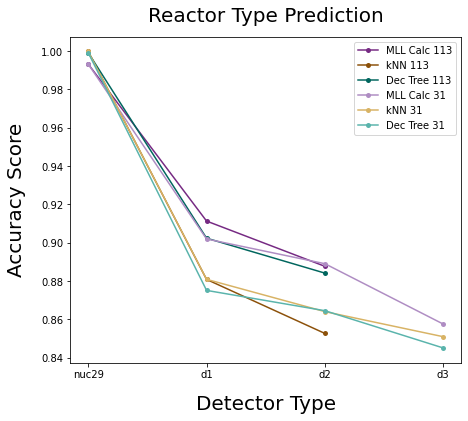

In [53]:
plot_curves('reactor', 'Reactor Type Prediction')

<Figure size 432x288 with 0 Axes>

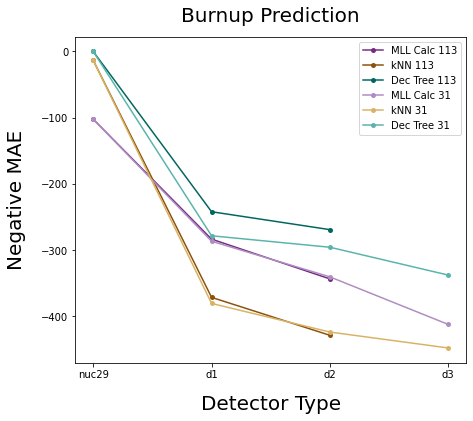

In [54]:
plot_curves('burnup', 'Burnup Prediction')

<Figure size 432x288 with 0 Axes>

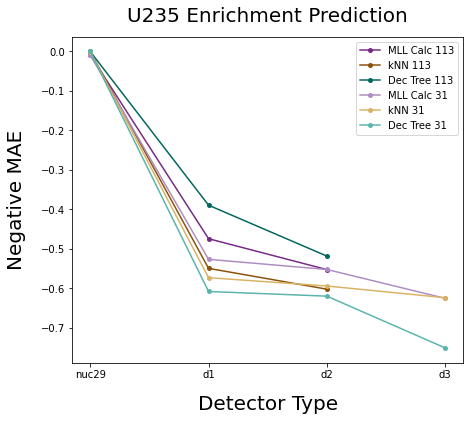

In [55]:
plot_curves('enrichment', 'U235 Enrichment Prediction')

<Figure size 432x288 with 0 Axes>

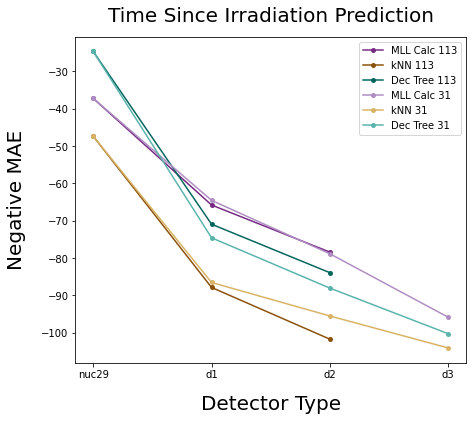

In [56]:
plot_curves('cooling', 'Time Since Irradiation Prediction')